# Module 10 - Regression Algorithms - Linear Regression, Ridge, and LASSO with Log-Log Transformations

In the last notebook, to explore the nonlinear relationships between the explanatory variables and predictor (mpg), I added polynomial terms through feature engineering. However, this made the model more complex because we introduced more X columns to the data.

To reduce complexity, I introduced LASSO which can set some coefficients to zero due to L1 penalties.

However, we can reduce nonlinearity by taking the log of both the target (mpg), and our continuous explanatory factors!

This will also prevent us from generating more columns of data points.

Let's start with our usual methods:

## Part A: Loading in Dataset

Import packages and set notebook & diagram output for SKLearn:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as                                                                                                                                        sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import set_config
set_config(display='diagram')

Import data and split X / y:

In [2]:
loc = "https://raw.githubusercontent.com/mhall-simon/python/main/data/car-mpg/auto-mpg.data"

df = pd.read_csv(loc, sep="\s+", header=None, na_values="?")

cols = {0:"mpg", 1:"cylinders", 2:"displacement", 3:"horsepower", 4:"weight", 5:"accel", 6:"year", 7:"origin", 8:"model"}
df = df.rename(columns=cols)

df = df.replace(np.nan, df.horsepower.mean())

df = df.drop("model", axis=1)

X = df.iloc[:,1:]
y = df.iloc[:,0]

Our usual train-test split:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107)

## Part B: Data Preprocessing & Pipeline

Listing out our categorical and numerical columns again:

In [4]:
categorical_columns = ['cylinders','origin','year']
numerical_columns = ['displacement','horsepower','weight','accel']

Here's where we start making our changes!

The numerical transformer needs to transform our explanatory continuous variables by taking the natural logarithm `np.log`. SKLearn does not have a transformer for this built in, however, we can use the `FunctionTransformer()` to apply our own functionality.

A few settings of note for the transformer is that we should also set the inverse function, so we can get back to linear space. Also, I set `check_inverse=True` so SKLearn checks that the transformer can get back to the original values. (I know the equations are inverses, however, it's always a good setting to keep checked.) 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

numerical_transformer = Pipeline(steps=[('log', FunctionTransformer(func=np.log, inverse_func=np.exp, check_inverse=True)),
                                        ('scaler', StandardScaler())])

Our transformer for one-hot encoding the categorical variables is still the same:

In [6]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

And now we can put the two transformers together:

In [7]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

And now we can put together our first one, Linear Regression:

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

linear = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(),
        func = np.log,
        inverse_func = np.exp
    )
)

linear.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

And we can easily generate our in-sample predictions for the model:

In [9]:
linear_pred_in = linear.predict(X_train)

## Part C: Evaluating Our Models

Let's bring back the same metrics we've been analyzing for our linear models:

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_score(y_train, linear_pred_in)
mean_squared_error(y_train, linear_pred_in)
mean_absolute_error(y_train, linear_pred_in)

0.8996946646077866

6.209291976132208

1.7163002917406607

And let's plot our linear regression predictions vs truths:

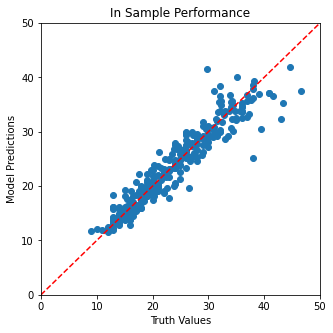

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_train, linear_pred_in)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("In Sample Performance")
plt.show();

Our model is doing really good! These are very similar results to the polynomial transformations, however, our model is much more simple!

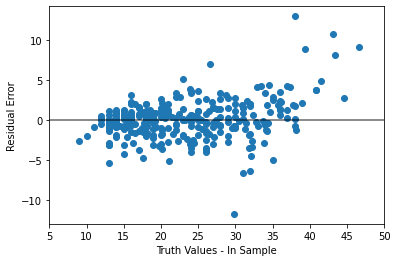

In [13]:
plt.scatter(y_train, y_train-linear_pred_in)
plt.xlabel("Truth Values - In Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

Let's grab out our names for coefficients:

In [16]:
numerical_names = numerical_columns

categorical_names = linear.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names(input_features=categorical_columns)

feature_names = np.concatenate([numerical_names, categorical_names])
feature_names

array(['displacement', 'horsepower', 'weight', 'accel', 'cylinders_3',
       'cylinders_4', 'cylinders_5', 'cylinders_6', 'cylinders_8',
       'origin_1', 'origin_2', 'origin_3', 'year_70', 'year_71',
       'year_72', 'year_73', 'year_74', 'year_75', 'year_76', 'year_77',
       'year_78', 'year_79', 'year_80', 'year_81', 'year_82'],
      dtype=object)

In [19]:
coefs = pd.DataFrame(
    linear.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['coef'], index=feature_names
)

coefs.head()

,coef
displacement,-0.021479
horsepower,-0.062886
weight,-0.168044
accel,-0.028467
cylinders_3,-0.244952


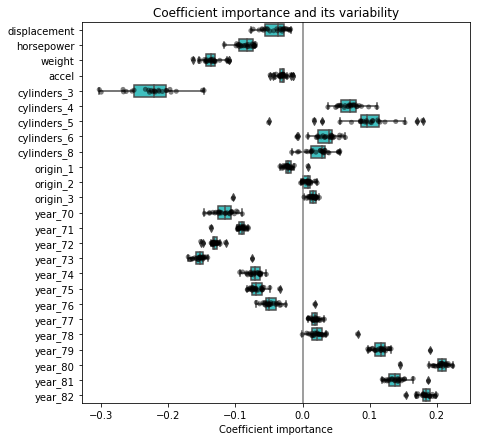

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    linear, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

cv_coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ for est in cv_model['estimator']],
    columns=feature_names)

plt.figure(figsize=(9,7))
sns.stripplot(data=cv_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=cv_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)
plt.show();

And let's analyze our out of sample statistics:

In [20]:
linear_pred_out = linear.predict(X_test)

In [22]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, linear_pred_in), mean_squared_error(y_train, linear_pred_in), mean_absolute_error(y_train, linear_pred_in))
metrics['out'] = (r2_score(y_test, linear_pred_out), mean_squared_error(y_test, linear_pred_out), mean_absolute_error(y_test, linear_pred_out))

metrics

,in,out
r2,0.899695,0.889230
mse,6.209292,6.415315
mae,1.716300,1.934722


Our out of sample performance with the log-log model is still really high, and is about 0.889!

Now, let's look at our Ridge and LASSO models quickly:

In [23]:
from sklearn.linear_model import RidgeCV

ridge_cv = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10,10,50)),
        func = np.log,
        inverse_func = np.exp
    )
)

ridge_cv.fit(X_train, y_train)

ridge_cv[-1].regressor_.alpha_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregresso...
       6.25055193e-01, 1.59985872e+00, 4.09491506e+00, 1.04811313e+01,
       2.68269580e+01, 6.86648845e+01, 1.75751062e+02, 4.49843267e+02,
       1.15139540e+03, 2.94705170e+03, 7.54312006e+03, 1.93069773e+04,
       4.94171336e+04, 1.26485522e+05, 3.23745754e+05, 8.28642773e+05,
       2.12095089e+06, 5.42867544e+06, 1.38949549e+07, 3.55648031e+07,
       9.10298178e+07, 2.32995181e+08, 5.96362332e+08, 1.52641797e+09,
       3.90693994e+09, 1.00000000e+10]))))])

1.8420699693267165e-07

In [25]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1.8420699693267165e-07),
        func = np.log,
        inverse_func = np.exp
    )
)

In [26]:
ridge.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=1.8420699693267165e-07)))])

In [27]:
ridge_pred_in = ridge.predict(X_train)
ridge_pred_out = ridge.predict(X_test)

In [28]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, ridge_pred_in), mean_squared_error(y_train, ridge_pred_in), mean_absolute_error(y_train, ridge_pred_in))
metrics['out'] = (r2_score(y_test, ridge_pred_out), mean_squared_error(y_test, ridge_pred_out), mean_absolute_error(y_test, ridge_pred_out))

metrics

,in,out
r2,0.899773,0.890009
mse,6.204452,6.370245
mae,1.717340,1.929184


In [29]:
from sklearn.linear_model import LassoCV

lasso_cv = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=np.logspace(-10,10,50), max_iter=1000000),
        func = np.log,
        inverse_func = np.exp
    )
)

lasso_cv.fit(X_train, y_train)
lasso_cv[-1].regressor_.alpha_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregresso...
       2.68269580e+01, 6.86648845e+01, 1.75751062e+02, 4.49843267e+02,
       1.15139540e+03, 2.94705170e+03, 7.54312006e+03, 1.93069773e+04,
       4.94171336e+04, 1.26485522e+05, 3.23745754e+05, 8.28642773e+05,
       2.12095089e+06, 5.42867544e+06, 1.38949549e+07, 3.55648031e+07,
       9.10298178e+07, 2.32995181e+08, 5.96362332e+08, 1.52641797e+09,
       3.90693994e+09, 1.00000000e+10]),
                                                              max_iter=1000000)))])

0.000339322177189533

In [30]:
from sklearn.linear_model import Lasso

lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=0.000339322177189533, max_iter=100000),
        func = np.log,
        inverse_func = np.exp
    )
)

lasso.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso(alpha=0.000339322177189533,
                                                            max_iter=100000)))])

In [31]:
lasso_pred_in = lasso.predict(X_train)
lasso_pred_out = lasso.predict(X_test)

In [32]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, lasso_pred_in), mean_squared_error(y_train, lasso_pred_in), mean_absolute_error(y_train, lasso_pred_in))
metrics['out'] = (r2_score(y_test, lasso_pred_out), mean_squared_error(y_test, lasso_pred_out), mean_absolute_error(y_test, lasso_pred_out))

metrics

,in,out
r2,0.899055,0.889662
mse,6.248860,6.390333
mae,1.726252,1.933950


Ridge still appears to be performing the best, most likely due to the fact that there is smoothing applied across all linear coefficients!

Why is Log-Log an excellent option for data analysis? We prevent introducing complexity into our model through polynomial terms, and the underlying data relationship may not actually be polynomial! It may be logarithmic!

Let's look at and analyze the coefficients for continuous variables in the next notebook and how they form the models we're looking at.